# Análisis de Los Resultados

En este notebook se desarrolla el código correspondiente a la sección 4.4 de la memoria: Análisis por paciente y por grupos clínicos.

## 0. Montar Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow

## 1. Carga de Los Datos

In [4]:
import os
import pandas as pd

# Definimos la ruta base donde están los archivos CSV
ruta_datos = '/content/drive/My Drive/TFG/Datos'
# Preparamos el diccionario para almacenar los DataFrames de cada paciente
datos_pacientes = {}

for i in range(1, 54):
    nombre_archivo = f'811-{i}.csv'
    ruta_archivo = os.path.join(ruta_datos, nombre_archivo)
    try:
        # Cargamos los datos y eliminamos filas con valores ausentes
        df = pd.read_csv(
            ruta_archivo,
            skiprows=2,
            # COLUMNAS DE INTERES
            usecols=[
                'Historial de glucosa mg/dL',
                'Sello de tiempo del dispositivo'
            ]
        ).dropna().copy()

        # Normalizamos los nombres de las columnas para el análisis
        df.rename(columns={
            'Historial de glucosa mg/dL': 'Historial_Glucosa',
            'Sello de tiempo del dispositivo': 'Timestamp'
        }, inplace=True)

        # Almacenamos el DataFrame correspondiente al paciente i
        datos_pacientes[f'paciente{i}'] = df

    except Exception as error:
        print(f"Error al procesar {nombre_archivo}: {error}")

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Concatenamos todos los valores de glucosa y creamos un DataFrame con nombre de columna
valores_glucosa = pd.concat(
    [df['Historial_Glucosa'] for df in datos_pacientes.values()]
)

valores_glucosa_df = valores_glucosa.to_frame(name='Historial_Glucosa')

# Ajustamos el scaler usando el DataFrame
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(valores_glucosa_df)

# Preprocesamos cada paciente usando el scaler ya ajustado
datos_preprocesados = {}
for paciente_id, df in datos_pacientes.items():
    df = df.copy()

    # Convertimos el sello de tiempo y ordenamos las medicione
    df['Timestamp'] = pd.to_datetime(
        df['Timestamp'], dayfirst=True, errors='coerce')

    df = df.sort_values('Timestamp').set_index('Timestamp')

    # Remuestreamos cada 15 minutos y rellenamos huecos por interpolación lineal
    df = (
        df.resample('15min')
          .mean()
          .interpolate(method='linear')
          .reset_index()
    )

    # Normalizamos los valores de glucosa entre 0 y 1
    df['Glucosa_Normalizada'] = scaler.transform(
        df[['Historial_Glucosa']]
    )

    datos_preprocesados[paciente_id] = df

In [6]:
import numpy as np

"""
Creación de las series temporales para entrenar modelos. En este caso para un
horizonte de 60 minutos. (h=4)
"""

# Definimos el mapeo de cada paciente a un índice numérico
claves = list(datos_preprocesados.keys())
mapeo_paciente_indice = {paciente: idx for idx, paciente in enumerate(claves)}

# Inicializamos las listas para secuencias, etiquetas y paciente índice
secuencias, etiquetas, paciente_indices = [], [], []

# Generamos ventanas deslizantes de glucosa por paciente
for paciente, df in datos_preprocesados.items():
    valores_glucosa = df['Historial_Glucosa'].values

    # Para cada bloque de 10 registros, guardamos la secuencia y su etiqueta
    for inicio in range(0, len(valores_glucosa) - 13, 10):
        ventana = valores_glucosa[inicio: inicio + 10]
        objetivo = valores_glucosa[inicio + 13]

        secuencias.append(ventana)
        etiquetas.append(objetivo)
        paciente_indices.append(mapeo_paciente_indice[paciente])

# Convertimos a arrays NumPy con la forma requerida para modelos de series temporales
X_secuencias = np.array(secuencias).reshape(-1, 10, 1)
X_indices_pacientes = np.array(paciente_indices)
y = np.array(etiquetas)

In [7]:
from sklearn.model_selection import train_test_split

# Dividir los datos en TRAIN (80%) y TEST (20%)
X_secuencias_train, X_secuencias_test, X_indices_train, X_indices_test, y_train, y_test = train_test_split(
    X_secuencias, X_indices_pacientes, y, test_size=0.2, random_state=42
)

# Dividir TRAIN en TRAIN (80%) y VALIDATION (20%)
X_secuencias_train, X_secuencias_val, X_indices_train, X_indices_val, y_train, y_val = train_test_split(
    X_secuencias_train, X_indices_train, y_train, test_size=0.2, random_state=42
)

## 2. Carga del Modelo

Para este análisis se decidió trabajar con un horizonte temporal clínicamente relevante, pero no excesivamente amplio, con el fin de evitar un incremento significativo en el error de predicción de los modelos cargados. En concreto, se seleccionó el horizonte 4, que corresponde a la predicción del nivel de glucosa con una antelación de una hora.

En esta sección se carga un modelo previamente entrenado para dicho horizonte.

In [11]:
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Definimos la ruta al directorio de modelos y al archivo del modelo
ruta_modelos = '/content/drive/My Drive/TFG/Modelos'
modelo_path = os.path.join(ruta_modelos, 'modelo_tiempo_futuro_1h.keras')

# Cargamos el modelo entrenado
modelo = load_model(modelo_path)

# Realizamos predicciones sobre el conjunto de test
glucosa_pred = modelo.predict([X_secuencias_test, X_indices_test]).flatten()
glucosa_real = y_test

2001/2001 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


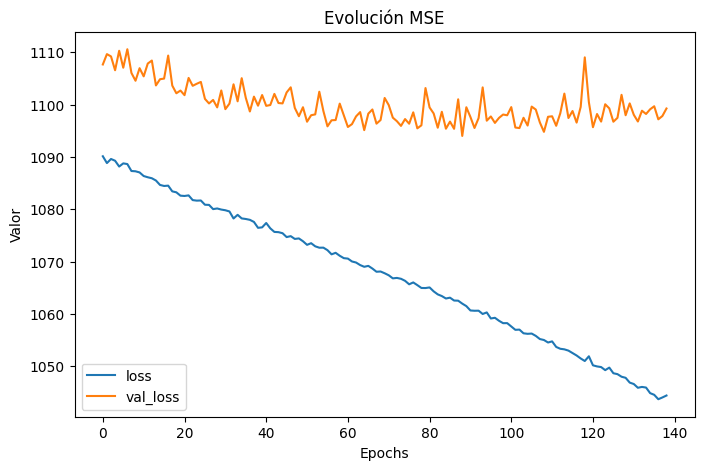

In [12]:
import pickle
import matplotlib.pyplot as plt

ruta_base = '/content/drive/My Drive/TFG/Modelos/'
ruta_history_pkl = f"{ruta_base}history_tiempo_futuro_1h.pkl"

# Cargamos el historial desde pickle
with open(ruta_history_pkl, 'rb') as f:
    loaded_history = pickle.load(f)  # Rename to loaded_history

# Seleccionamos las métricas a graficar
metrics = ['loss', 'val_loss']
selected_history = {key: loaded_history[key] for key in metrics}

# Cortamos los valores a partir de la iteración 5 (índice 4)
selected_history = {key: value[100:] for key, value in selected_history.items()}

# Creamos el DataFrame y hacemos la gráfica
pd.DataFrame(selected_history).plot(figsize=(8, 5))
plt.title('Evolución MSE')
plt.xlabel('Epochs')
plt.ylabel('Valor')
plt.show()

## 3.Análisis de Los Resultados




### 3.1. Análisis_Individual

In [13]:
from collections import defaultdict
from sklearn.metrics import mean_squared_error

claves_pacientes = [f'paciente{i}' for i in range(1, 54)]

# Agrupamos valores reales y predichos por paciente
resultados = defaultdict(lambda: {"reales": [], "predichos": []})
for i, pac_idx in enumerate(X_indices_test):
    pac_id = claves_pacientes[pac_idx]
    resultados[pac_id]["reales"].append(y_test[i])
    resultados[pac_id]["predichos"].append(glucosa_pred[i])

# Calculamos MSE y RMSE por paciente
mse_paciente = {}
for pac_id, vals in resultados.items():
    mse = mean_squared_error(vals["reales"], vals["predichos"])
    mse_paciente[pac_id] = mse

# Creamos DataFrame con MSE y RMSE, y ordenamos por MSE descendente
df_mse = pd.DataFrame.from_dict(
    mse_paciente, orient="index", columns=["MSE"]
).reset_index().rename(columns={"index": "Paciente"})
df_mse["RMSE (mg/dL)"] = np.sqrt(df_mse["MSE"]).round(2)
df_mse = df_mse.sort_values("MSE", ascending=False).reset_index(drop=True)

# Mostramos los 10 pacientes con mayor error
display(df_mse.head(10))


,Paciente,MSE,RMSE (mg/dL)
0,paciente40,2621.617387,51.20
1,paciente46,2175.360330,46.64
2,paciente33,2081.191147,45.62
3,paciente20,1998.663440,44.71
4,paciente16,1957.970294,44.25
5,paciente37,1727.174666,41.56
6,paciente5,1630.455601,40.38
7,paciente28,1587.868309,39.85
8,paciente2,1545.796206,39.32
9,paciente9,1534.740745,39.18


In [14]:
# Definimos mapeo de IDs de pacientes
claves_pacientes = [f'paciente{i}' for i in range(1, 54)]

# Agrupamos valores reales y predichos por paciente
resultados = defaultdict(lambda: {"reales": [], "predichos": []})
for i, pac_idx in enumerate(X_indices_test):
    pac_id = claves_pacientes[pac_idx]
    resultados[pac_id]["reales"].append(y_test[i])
    resultados[pac_id]["predichos"].append(glucosa_pred[i])

# Calculamos MSE por paciente
mse_por_paciente = {
    pac_id: mean_squared_error(vals["reales"], vals["predichos"])
    for pac_id, vals in resultados.items()
}

# Creamos DataFrame con MSE y RMSE
df_mse = (
    pd.DataFrame.from_dict(mse_por_paciente, orient="index", columns=["MSE"])
    .reset_index()
    .rename(columns={"index": "Paciente"})
)
df_mse["RMSE (mg/dL)"] = np.sqrt(df_mse["MSE"]).round(2)

# Ordenamos de menor a mayor error y mostramos los 10 con menor RMSE
df_mejor = df_mse.sort_values("RMSE (mg/dL)", ascending=True).head(10).reset_index(drop=True)
display(df_mejor)


,Paciente,MSE,RMSE (mg/dL)
0,paciente45,326.652056,18.07
1,paciente43,329.611812,18.16
2,paciente48,400.115810,20.00
3,paciente44,551.664096,23.49
4,paciente42,557.048766,23.60
5,paciente39,597.053562,24.43
6,paciente4,612.906451,24.76
7,paciente49,658.401143,25.66
8,paciente47,667.874424,25.84
9,paciente30,668.833109,25.86


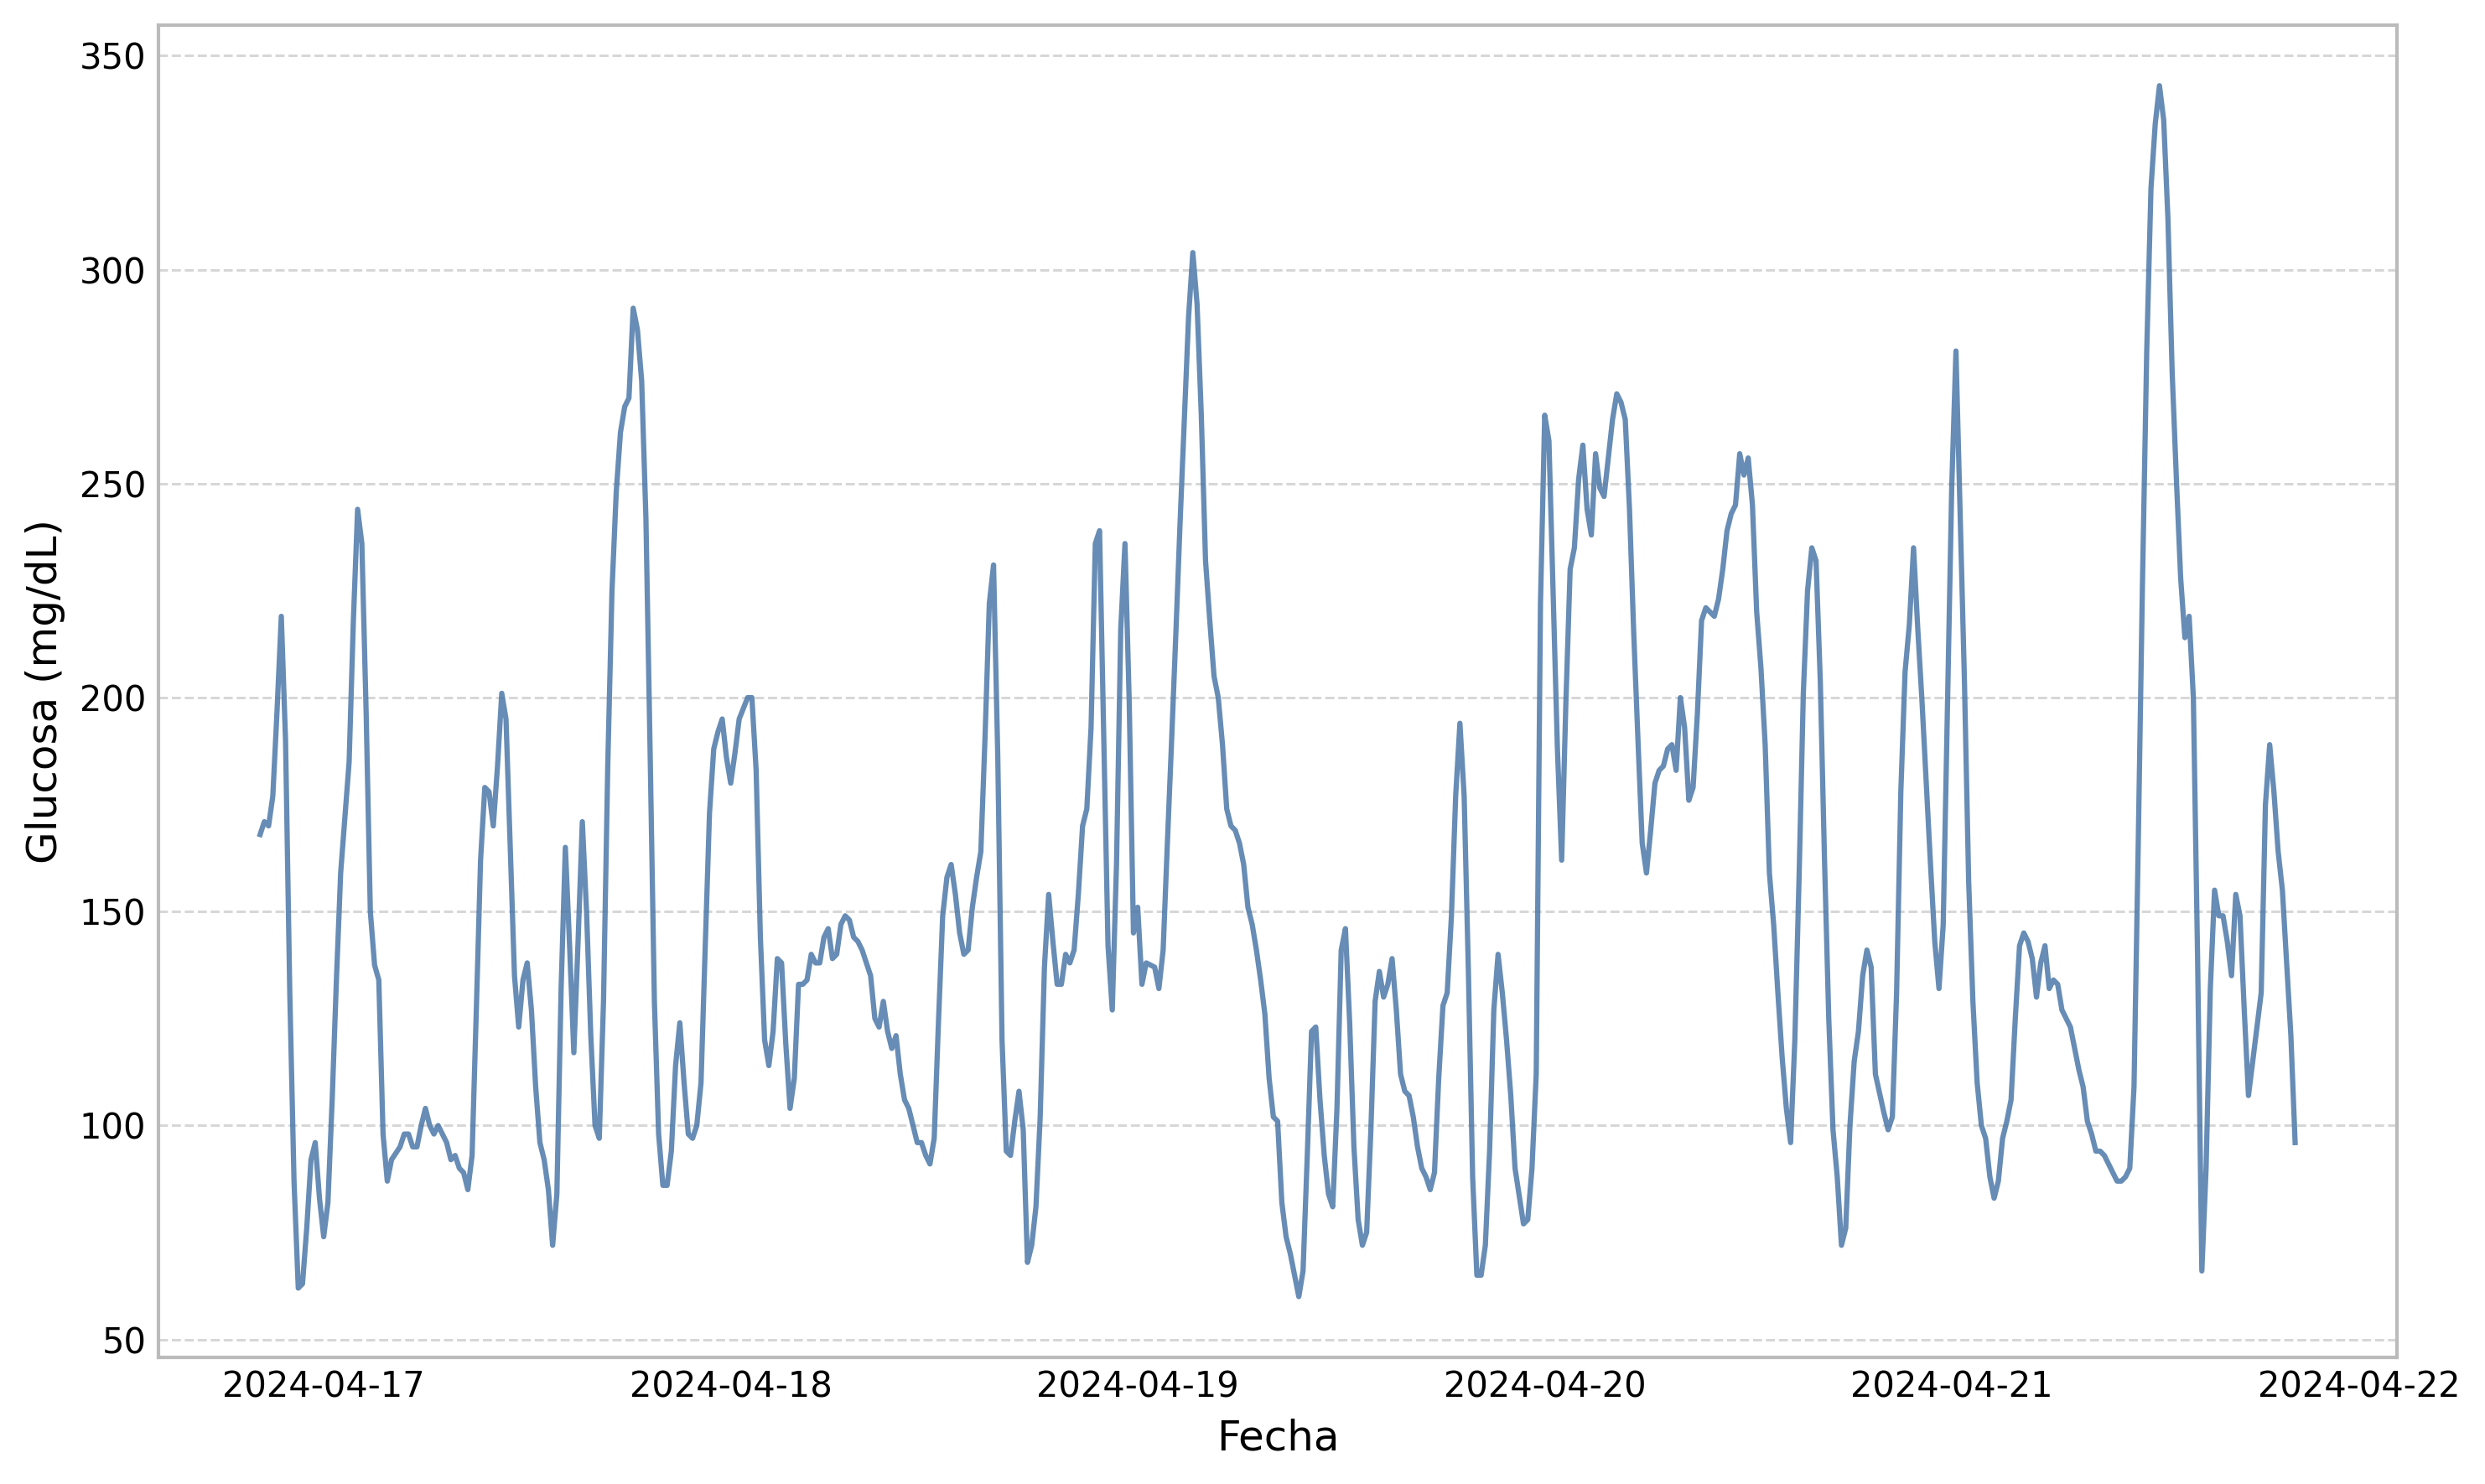

In [15]:
# Cargamos los datos del paciente 40
df = datos_preprocesados['paciente40'].copy()

# Filtramos registros de los últimos 5 días
fecha_max = df['Timestamp'].max()
fecha_min = fecha_max - pd.Timedelta(days=5)
df_reciente = df[df['Timestamp'] >= fecha_min]

# Creamos figura y ejes con el estilo acordado
figura, eje = plt.subplots(figsize=(10, 6), dpi=300)
color_borde = '#BBBBBB'
color_linea = '#4C78A8'
for borde in ['top', 'bottom', 'left', 'right']:
    eje.spines[borde].set_color(color_borde)
    eje.spines[borde].set_linewidth(1.0)

# Representamos la serie de glucosa en el tiempo
eje.plot(
    df_reciente['Timestamp'],
    df_reciente['Historial_Glucosa'],
    color=color_linea,
    linewidth=1.5,
    alpha=0.85,
    zorder=2
)

# Etiquetamos los ejes
eje.set_xlabel('Fecha', fontsize=12)
eje.set_ylabel('Glucosa (mg/dL)', fontsize=12)

# Configuramos cuadrícula horizontal
eje.yaxis.grid(
    True,
    color=color_borde,
    linestyle='--',
    linewidth=0.7,
    alpha=0.6
)
eje.set_axisbelow(True)

# Ajustamos los ticks (sin guiones)
eje.tick_params(axis='both', which='both', length=0, labelsize=10)

# Guardamos la figura en PDF y la mostramos
plt.tight_layout()
plt.savefig('historial_glucosa_paciente40.pdf')
plt.show()


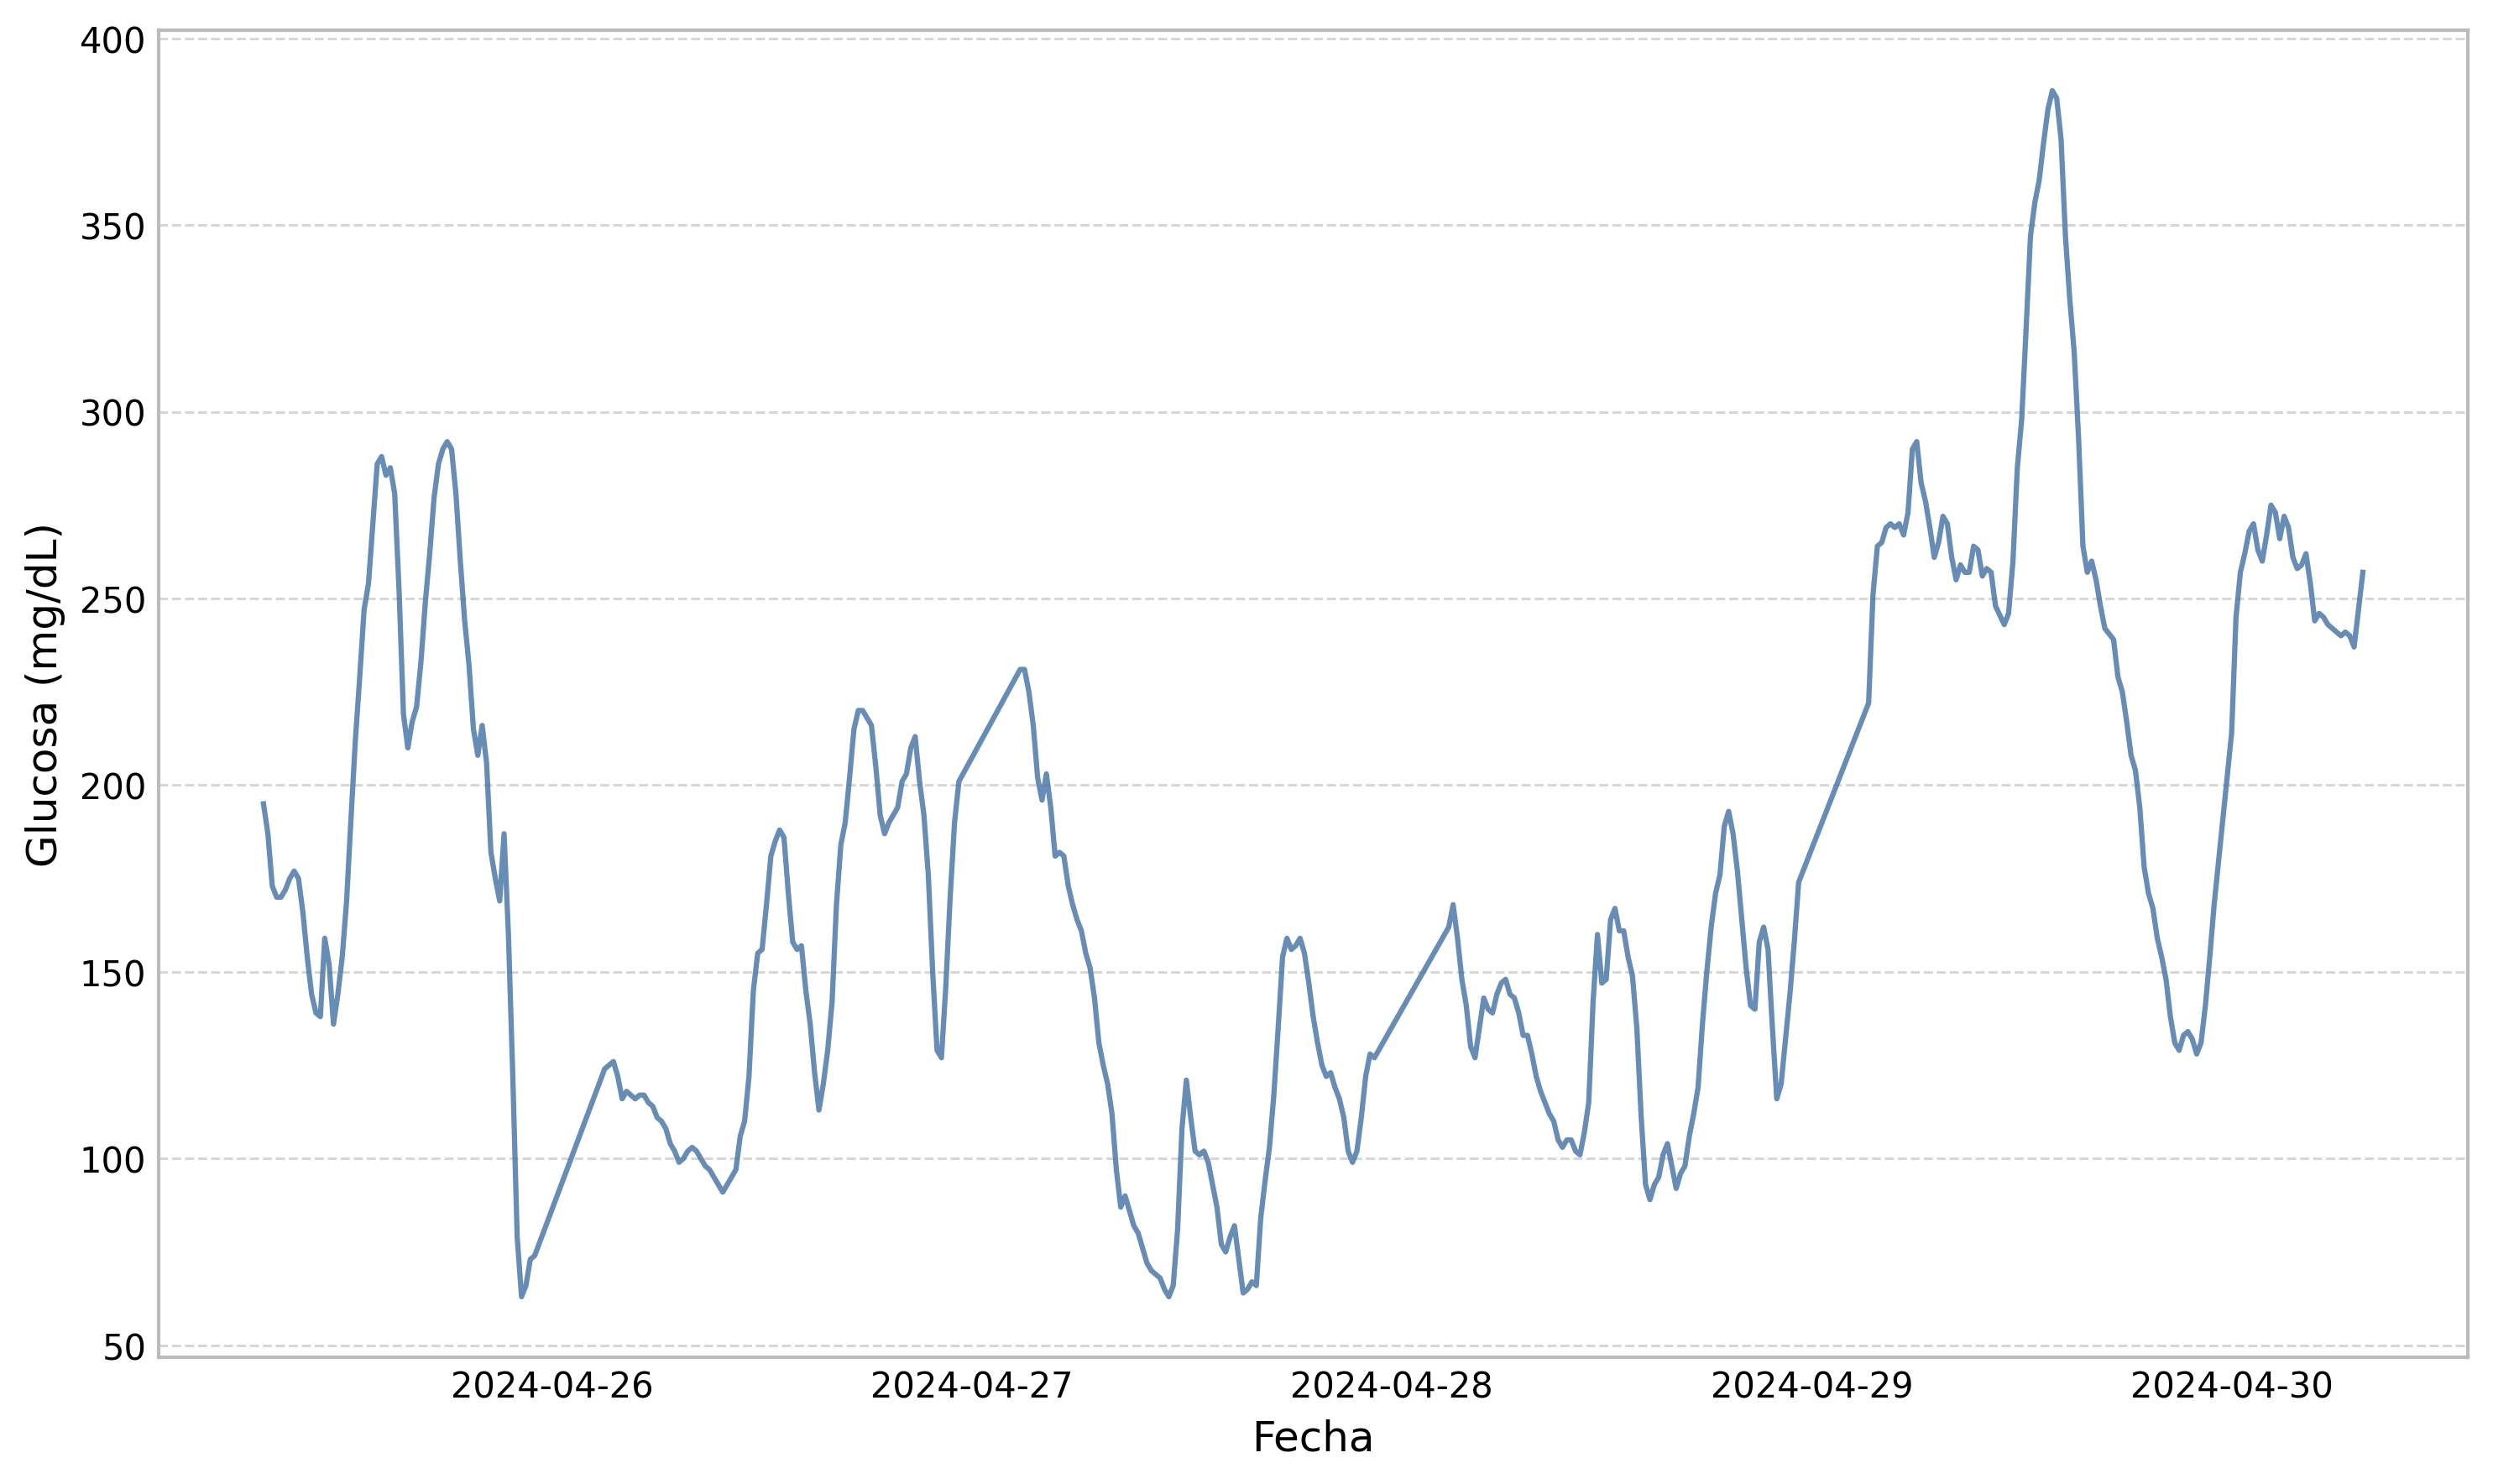

In [16]:
# Cargamos los datos del paciente 43
df = datos_preprocesados['paciente43'].copy()

# Filtramos registros de los últimos 5 días
fecha_max = df['Timestamp'].max()
fecha_min = fecha_max - pd.Timedelta(days=5)
df_reciente = df[df['Timestamp'] >= fecha_min]

# Creamos figura y ejes con el estilo acordado
figura, eje = plt.subplots(figsize=(10, 6), dpi=300)
color_borde = '#BBBBBB'
color_linea = '#4C78A8'
for borde in ['top', 'bottom', 'left', 'right']:
    eje.spines[borde].set_color(color_borde)
    eje.spines[borde].set_linewidth(1.0)

# Representamos la serie de glucosa en el tiempo
eje.plot(
    df_reciente['Timestamp'],
    df_reciente['Historial_Glucosa'],
    color=color_linea,
    linewidth=1.5,
    alpha=0.85,
    zorder=2
)

# Etiquetamos los ejes
eje.set_xlabel('Fecha', fontsize=12)
eje.set_ylabel('Glucosa (mg/dL)', fontsize=12)

# Configuramos cuadrícula horizontal
eje.yaxis.grid(
    True,
    color=color_borde,
    linestyle='--',
    linewidth=0.7,
    alpha=0.6
)
eje.set_axisbelow(True)

# Ajustamos los ticks (sin guiones)
eje.tick_params(axis='both', which='both', length=0, labelsize=10)

# Guardamos la figura en PDF y la mostramos
plt.tight_layout()
plt.savefig('historial_glucosa_paciente43.pdf')
plt.show()

In [17]:
# Cargamos la información clínica de todos los pacientes
pacientes_df = pd.read_csv('/content/drive/My Drive/TFG/Datos/Info_Pacientes.csv')

# IDs de los 5 pacientes con mayor error
ids_error_alto = ['811-40', '811-46', '811-33', '811-20', '811-16']

# Columnas clínicas que queremos mostrar
columnas_clinicas = [
    'Record ID',
    'Edad al momento de ser incluido en el proyecto',
    'Sexo',
    'Tipo de diabetes',
    'IMC',
    'Tipo de tratamiento',
    'Unidades totales de insulina (UI/24h)',
    'HbA1c valor',
    'Promedio de hemoglobinas glicadas',
    '¿Existen complicaciones microvasculares?',
    '¿Existen complicaciones macrovasculares?'
]

# Filtramos el DataFrame original
df_filtrado = pacientes_df[pacientes_df['Record ID'].isin(ids_error_alto)].copy()

#
df_filtrado['Record ID'] = pd.Categorical(
    df_filtrado['Record ID'],
    categories=ids_error_alto,
    ordered=True
)

# Reordenamos según esa categoría y seleccionamos columnas
df_filtrado = (
    df_filtrado
    .sort_values('Record ID')
    [columnas_clinicas]
)

# Mostramos transpuesto para que cada paciente sea una columna
print("Datos clínicos de los 5 pacientes con mayor error del modelo:")
display(df_filtrado.set_index('Record ID').T)

Datos clínicos de los 5 pacientes con mayor error del modelo:


Record ID,811-40,811-46,811-33,811-20,811-16
Edad al momento de ser incluido en el proyecto,24,60,23,25,42
Sexo,Varón,Varón,Varón,Varón,Varón
Tipo de diabetes,Diabetes mellitus tipo 1,LADA,Diabetes mellitus tipo 1,Diabetes mellitus tipo 1,Diabetes mellitus tipo 1
IMC,22.9,21.8,27.3,23.5,30.2
Tipo de tratamiento,MDI,MDI,MDI,MDI,MDI
Unidades totales de insulina (UI/24h),60.0,30.0,59.0,71.0,100.0
HbA1c valor,6.8,8.9,9.0,8.3,8.1
Promedio de hemoglobinas glicadas,7.4,9.1,9.0,8.5,8.0
¿Existen complicaciones microvasculares?,No,Sí,No,No,Sí
¿Existen complicaciones macrovasculares?,No,No,No,No,No


In [18]:
# IDs de los 5 pacientes con menor error
ids_error_bajo = ['811-45', '811-43', '811-48', '811-44', '811-42']

# Filtramos el DataFrame original
df_filtrado = pacientes_df[pacientes_df['Record ID'].isin(ids_error_alto)].copy()

#
df_filtrado['Record ID'] = pd.Categorical(
    df_filtrado['Record ID'],
    categories=ids_error_bajo,
    ordered=True
)

# Reordenamos según esa categoría y seleccionamos columnas
df_filtrado = (
    df_filtrado
    .sort_values('Record ID')
    [columnas_clinicas]
)

# Mostramos transpuesto para que cada paciente sea una columna
print("Datos clínicos de los 5 pacientes con menor error del modelo:")
display(df_filtrado.set_index('Record ID').T)

Datos clínicos de los 5 pacientes con menor error del modelo:


Record ID,NaN,NaN,NaN,NaN,NaN
Edad al momento de ser incluido en el proyecto,42,25,23,24,60
Sexo,Varón,Varón,Varón,Varón,Varón
Tipo de diabetes,Diabetes mellitus tipo 1,Diabetes mellitus tipo 1,Diabetes mellitus tipo 1,Diabetes mellitus tipo 1,LADA
IMC,30.2,23.5,27.3,22.9,21.8
Tipo de tratamiento,MDI,MDI,MDI,MDI,MDI
Unidades totales de insulina (UI/24h),100.0,71.0,59.0,60.0,30.0
HbA1c valor,8.1,8.3,9.0,6.8,8.9
Promedio de hemoglobinas glicadas,8.0,8.5,9.0,7.4,9.1
¿Existen complicaciones microvasculares?,Sí,No,No,No,Sí
¿Existen complicaciones macrovasculares?,No,No,No,No,No


### 3.2. Análisis por Subgrupos Clínicos

In [19]:
# Agrupamos valores reales y predichos por paciente
resultados = defaultdict(lambda: {"reales": [], "predichos": []})
for i, pac_idx in enumerate(X_indices_test):
    paciente = f'paciente{pac_idx+1}'
    resultados[paciente]["reales"].append(y_test[i])
    resultados[paciente]["predichos"].append(glucosa_pred[i])

# Calculamos MSE, RMSE y MAE por paciente
metricas = []
for paciente, vals in resultados.items():
    reales    = vals["reales"]
    predichos = vals["predichos"]
    mse  = mean_squared_error(reales, predichos)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(reales, predichos)
    metricas.append({
        "Paciente": paciente,
        "MSE": mse,
        "RMSE (mg/dL)": rmse,
        "MAE (mg/dL)": mae
    })

df_metricas = pd.DataFrame(metricas)

# Añadimos la información de IMC de cada paciente
info = pd.read_csv('/content/drive/My Drive/TFG/Datos/Info_Pacientes.csv')
mapa = pd.DataFrame({
    "Paciente":  [f'paciente{i}' for i in range(1, 54)],
    "Record ID": [f'811-{i}'       for i in range(1, 54)]
})
df_error = (
    df_metricas
    .merge(mapa, on="Paciente")
    .merge(info[['Record ID', 'IMC']], on="Record ID")
)

# Creamos categorías de IMC
limites  = [0, 18.5, 25, 30, np.inf]
etiquetas = ['Infrapeso', 'Normopeso', 'Sobrepeso', 'Obesidad']
df_error['Categoria_IMC'] = pd.cut(
    df_error['IMC'],
    bins=limites,
    labels=etiquetas,
    right=False,
    include_lowest=True
)

# Agrupamos por categoría y calculamos métricas
df_grupos = (
    df_error
    .groupby('Categoria_IMC', observed=True)
    .agg(
        RMSE_media   = ('RMSE (mg/dL)', 'mean'),
        RMSE_mediana = ('RMSE (mg/dL)', 'median'),
        MSE_media   = ('MSE', 'mean'),
        MSE_mediana = ('MSE', 'median'),
        MAE_media    = ('MAE (mg/dL)', 'mean'),
        MAE_mediana  = ('MAE (mg/dL)', 'median'),
        n_pacientes  = ('Paciente',       'count')
    )
    .reset_index()
)

# Mostramos resultados por grupo clínico
print("Métricas del modelo por categoría de IMC:")
display(df_grupos)


Métricas del modelo por categoría de IMC:


,Categoria_IMC,RMSE_media,RMSE_mediana,MSE_media,MSE_mediana,MAE_media,MAE_mediana,n_pacientes
0,Infrapeso,36.800119,36.800119,1354.248746,1354.248746,26.931245,26.931245,1
1,Normopeso,35.519769,35.358423,1319.609430,1250.218111,24.792677,25.079700,17
2,Sobrepeso,31.233824,30.339883,1024.530616,920.508478,21.398610,22.076958,23
3,Obesidad,31.519882,31.823158,1028.841582,1012.713388,22.806825,23.078492,11


In [20]:
# Calculamos MSE, RMSE y MAE por paciente (igual que antes)
resultados = defaultdict(lambda: {"reales": [], "predichos": []})
for i, idx in enumerate(X_indices_test):
    paciente = f'paciente{idx+1}'
    resultados[paciente]["reales"].append(y_test[i])
    resultados[paciente]["predichos"].append(glucosa_pred[i])

metricas = []
for paciente, vals in resultados.items():
    reales    = vals["reales"]
    predichos = vals["predichos"]
    mse   = mean_squared_error(reales, predichos)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(reales, predichos)
    metricas.append({
        "Paciente":       paciente,
        "MSE":            mse,
        "RMSE (mg/dL)":   rmse,
        "MAE (mg/dL)":    mae
    })
df_metricas = pd.DataFrame(metricas)

# Unimos con la edad de cada paciente
info = pd.read_csv('/content/drive/My Drive/TFG/Datos/Info_Pacientes.csv')
mapa = pd.DataFrame({
    "Paciente":  [f'paciente{i}' for i in range(1, 54)],
    "Record ID": [f'811-{i}'       for i in range(1, 54)]
})
df_error = (
    df_metricas
    .merge(mapa, on="Paciente")
    .merge(info[['Record ID', 'Edad al momento de ser incluido en el proyecto']], on="Record ID")
    .rename(columns={"Edad al momento de ser incluido en el proyecto": "Edad"})
)

# Creamos grupos etarios de 10 en 10 años
bins   = list(range(0, 101, 10))
labels = [f'[{i}, {i+10})' for i in bins[:-1]]
df_error['Grupo_Edad'] = pd.cut(
    df_error['Edad'],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# Agrupamos por grupo etario y calculamos métricas agregadas
df_grupos_edad = (
    df_error
    .groupby('Grupo_Edad', observed=True)
    .agg(
        RMSE_media   = ('RMSE (mg/dL)', 'mean'),
        RMSE_mediana = ('RMSE (mg/dL)', 'median'),
        MSE_media   = ('MSE', 'mean'),
        MSE_mediana = ('MSE', 'median'),
        MAE_media    = ('MAE (mg/dL)', 'mean'),
        MAE_mediana  = ('MAE (mg/dL)', 'median'),
        n_pacientes  = ('Paciente',       'count')
    )
    .reset_index()
)

# Mostramos el error del modelo en cada grupo de edad
print("Métricas del modelo por grupo etario:")
display(df_grupos_edad)


Métricas del modelo por grupo etario:


,Grupo_Edad,RMSE_media,RMSE_mediana,MSE_media,MSE_mediana,MAE_media,MAE_mediana,n_pacientes
0,"[20, 30)",39.181864,39.656605,1596.182820,1576.266568,28.108920,28.798160,8
1,"[30, 40)",37.282062,36.248357,1395.496638,1313.943410,26.743172,27.086359,7
2,"[40, 50)",32.962319,31.987778,1108.912473,1023.217964,23.517878,23.569254,13
3,"[50, 60)",31.731298,31.866118,1032.814741,1017.778882,21.768635,22.134306,8
4,"[60, 70)",29.109866,27.670242,893.962485,765.642283,19.507427,19.263684,13
5,"[70, 80)",24.267953,21.802388,634.129455,478.582288,16.285297,14.548121,4


In [21]:
# Calculamos MSE, RMSE y MAE por paciente en el conjunto de test
resultados = defaultdict(lambda: {"reales": [], "predichos": []})
for i, pac_idx in enumerate(X_indices_test):
    clave = f'paciente{pac_idx+1}'
    resultados[clave]["reales"].append(y_test[i])
    resultados[clave]["predichos"].append(glucosa_pred[i])

metricas = []
for paciente, vals in resultados.items():
    reales    = vals["reales"]
    predichos = vals["predichos"]
    mse   = mean_squared_error(reales, predichos)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(reales, predichos)
    metricas.append({
        "Paciente":        paciente,
        "MSE":             mse,
        "RMSE (mg/dL)":    rmse,
        "MAE (mg/dL)":     mae
    })
df_metricas = pd.DataFrame(metricas)

# Unimos con el tipo de diabetes de cada paciente
info = pd.read_csv('/content/drive/My Drive/TFG/Datos/Info_Pacientes.csv')
mapa = pd.DataFrame({
    "Paciente":   [f'paciente{i}' for i in range(1, 54)],
    "Record ID":  [f'811-{i}'       for i in range(1, 54)]
})
df_error_tipo = (
    df_metricas
    .merge(mapa, on="Paciente")
    .merge(info[['Record ID', 'Tipo de diabetes']], on="Record ID")
    .rename(columns={"Tipo de diabetes": "Tipo_de_diabetes"})
)

# Agrupamos por tipo de diabetes y calculamos métricas agregadas
df_grupos_tipo = (
    df_error_tipo
    .groupby('Tipo_de_diabetes', observed=True)
    .agg(
        n_pacientes = ('Paciente',       'count'),
        RMSE_media   = ('RMSE (mg/dL)',   'mean'),
        RMSE_mediana = ('RMSE (mg/dL)',   'median'),
        MSE_media   = ('MSE',   'mean'),
        MSE_mediana = ('MSE',   'median'),
        MAE_media    = ('MAE (mg/dL)',    'mean'),
        MAE_mediana  = ('MAE (mg/dL)',    'median')
    )
    .reset_index()
)

# Calculamos porcentaje de pacientes por tipo
total = df_grupos_tipo['n_pacientes'].sum()
df_grupos_tipo['Porcentaje (%)'] = (df_grupos_tipo['n_pacientes'] / total * 100).round(2)

# Mostramos la tabla final
print("Métricas del modelo por tipo de diabetes:")
display(df_grupos_tipo)


Métricas del modelo por tipo de diabetes:


,Tipo_de_diabetes,n_pacientes,RMSE_media,RMSE_mediana,MSE_media,MSE_mediana,MAE_media,MAE_mediana,Porcentaje (%)
0,Diabetes mellitus tipo 1,41,34.446405,35.358423,1223.879738,1250.218111,24.603632,24.800864,77.36
1,LADA,12,26.665612,25.751298,766.273332,663.137784,16.828659,15.843843,22.64


In [22]:
# Calculamos MSE, RMSE y MAE por paciente en el conjunto de test
resultados = defaultdict(lambda: {"reales": [], "predichos": []})
for i, pac_idx in enumerate(X_indices_test):
    paciente = f'paciente{pac_idx+1}'
    resultados[paciente]["reales"].append(y_test[i])
    resultados[paciente]["predichos"].append(glucosa_pred[i])

metricas = []
for paciente, vals in resultados.items():
    reales    = vals["reales"]
    predichos = vals["predichos"]
    mse   = mean_squared_error(reales, predichos)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(reales, predichos)
    metricas.append({
        "Paciente":       paciente,
        "MSE":             mse,
        "RMSE (mg/dL)":   rmse,
        "MAE (mg/dL)":    mae
    })
df_metricas = pd.DataFrame(metricas)

# Unimos con el sexo de cada paciente
info = pd.read_csv('/content/drive/My Drive/TFG/Datos/Info_Pacientes.csv')
mapa = pd.DataFrame({
    "Paciente":   [f'paciente{i}' for i in range(1, 54)],
    "Record ID":  [f'811-{i}'       for i in range(1, 54)]
})
df_error_sexo = (
    df_metricas
    .merge(mapa, on="Paciente")
    .merge(info[['Record ID', 'Sexo']], on="Record ID")
    .rename(columns={"Sexo": "Sexo"})
)

# Agrupamos por sexo y calculamos número de pacientes y porcentaje
total_pacientes = df_error_sexo['Paciente'].nunique()
df_sexo = (
    df_error_sexo
    .groupby('Sexo', observed=True)
    .agg(
        n_pacientes = ('Paciente',    'nunique'),
        RMSE_media   = ('RMSE (mg/dL)',   'mean'),
        RMSE_mediana = ('RMSE (mg/dL)',   'median'),
        MSE_media   = ('MSE',   'mean'),
        MSE_mediana = ('MSE',   'median'),
        MAE_media    = ('MAE (mg/dL)',    'mean'),
        MAE_mediana  = ('MAE (mg/dL)',    'median')
    )
    .reset_index()
)


# Mostramos la tabla final
print("Métricas del modelo por sexo:")
display(df_sexo)


Métricas del modelo por sexo:


,Sexo,n_pacientes,RMSE_media,RMSE_mediana,MSE_media,MSE_mediana,MAE_media,MAE_mediana
0,Mujer,18,29.899329,28.972669,934.559397,839.496007,20.289296,19.390833
1,Varón,35,34.117201,33.818496,1215.779431,1143.690668,24.156727,24.293472


In [23]:
# Definimos la función de clasificación de HbA1c
def clasificar_hba1c(hba1c):
    if hba1c < 6.5:
        return 'Control óptimo'
    elif hba1c < 7.5:
        return 'Control aceptable'
    elif hba1c < 9.0:
        return 'Control mejorable'
    else:
        return 'Mal control'

# Calculamos MSE, RMSE y MAE por paciente sobre el conjunto de test
resultados = defaultdict(lambda: {"reales": [], "predichos": []})
for i, pac_idx in enumerate(X_indices_test):
    paciente = f'paciente{pac_idx+1}'
    resultados[paciente]["reales"].append(y_test[i])
    resultados[paciente]["predichos"].append(glucosa_pred[i])

metricas = []
for paciente, vals in resultados.items():
    reales    = vals["reales"]
    predichos = vals["predichos"]
    mse   = mean_squared_error(reales, predichos)
    rmse  = np.sqrt(mse)
    mae   = mean_absolute_error(reales, predichos)
    metricas.append({
        "Paciente":     paciente,
        "MSE":          mse,
        "RMSE (mg/dL)": rmse,
        "MAE (mg/dL)":  mae
    })
df_metricas = pd.DataFrame(metricas)

# Unimos MSE/MAE con el valor de HbA1c de cada paciente
info = pd.read_csv('/content/drive/My Drive/TFG/Datos/Info_Pacientes.csv')
mapa = pd.DataFrame({
    "Paciente":  [f'paciente{i}' for i in range(1, 54)],
    "Record ID": [f'811-{i}'       for i in range(1, 54)]
})
df_error = (
    df_metricas
    .merge(mapa, on="Paciente")
    .merge(info[['Record ID', 'HbA1c valor']], on="Record ID")
)

# Aplicamos la clasificación personalizada de HbA1c
df_error['Clasificación_HbA1c'] = df_error['HbA1c valor'].apply(clasificar_hba1c)

# Agrupamos por la nueva categoría y calculamos métricas agregadas
total = df_error['Paciente'].nunique()
df_hba1c = (
    df_error
    .groupby('Clasificación_HbA1c', observed=True)
    .agg(
        MSE_media       = ('MSE',           'mean'),
        MSE_mediana     = ('MSE',           'median'),
        RMSE_media      = ('RMSE (mg/dL)',  'mean'),
        RMSE_mediana    = ('RMSE (mg/dL)',  'median'),
        MAE_media       = ('MAE (mg/dL)',   'mean'),
        MAE_mediana     = ('MAE (mg/dL)',   'median'),
        n_pacientes     = ('Paciente',      'nunique')
    )
    .reset_index()
)
df_hba1c['Porcentaje (%)'] = (df_hba1c['n_pacientes'] / total * 100).round(2)

# Mostramos la tabla final con todas las métricas por categoría de HbA1c
print("Métricas del modelo por clasificación de HbA1c:")
display(df_hba1c)


Métricas del modelo por clasificación de HbA1c:


,Clasificación_HbA1c,MSE_media,MSE_mediana,RMSE_media,RMSE_mediana,MAE_media,MAE_mediana,n_pacientes,Porcentaje (%)
0,Control aceptable,1103.822594,1134.636426,32.507404,33.684365,23.566071,24.567013,21,39.62
1,Control mejorable,1180.459141,985.462176,33.202765,31.389070,23.055947,23.151975,14,26.42
2,Control óptimo,1008.358804,915.517286,31.336614,30.257516,20.964045,19.517982,9,16.98
3,Mal control,1176.935284,1084.332603,33.640691,32.929206,22.705072,20.626139,9,16.98
